**Random forest , KNN**

In [ ]:
!pip install yfinance
!pip install finta

In [ ]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

In [ ]:
"""
Defining some constants for data mining
"""

NUM_DAYS = 10000     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'SPY'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']


[*********************100%***********************]  1 of 1 completed
                 open       high        low      close  Adj Close  volume
Date                                                                     
1995-01-06  46.093750  46.250000  45.906250  46.046875  28.179764  448400
1995-01-09  46.031250  46.093750  46.000000  46.093750  28.208450   36800
1995-01-10  46.203125  46.390625  46.140625  46.140625  28.237150  229800
1995-01-11  46.296875  46.296875  45.812500  46.171875  28.256264  222400
1995-01-12  46.125000  46.218750  46.031250  46.187500  28.265825   40300


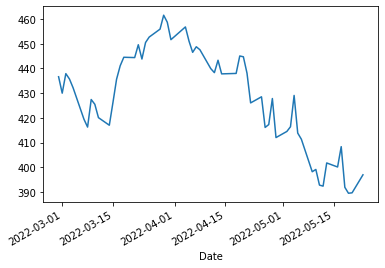

In [ ]:
"""
Next we pull the historical data using yfinance
Rename the column names because finta uses the lowercase names
"""

start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

tmp = data.iloc[-60:]
tmp['close'].plot()

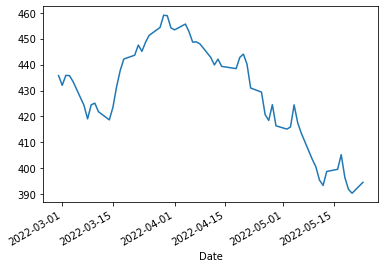

In [ ]:
"""
Next we clean our data and perform feature engineering to create new technical indicator features that our
model can learn from
"""

def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [ ]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data

data = _get_indicator_data(data)
print(data.columns)

Index(['close', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', 'MFV',
       '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI',
       '14 period EMV', 'VIm', 'VIp', 'ema50', 'ema21', 'ema15', 'ema5',
       'normVol'],
      dtype='object')


In [ ]:
live_pred_data = data.iloc[-16:-11]

In [ ]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,14 period RSI,MACD,SIGNAL,14 period STOCH %K,MFV,14 period ATR,MOM,14 period MFI,ROC,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
Date,,,,,,,,,,,,,,,,,,,,
2022-04-26,29.242136,-3.520320,-0.727139,6.977529,4.014970e+10,7.699806,-21.994010,18.145632,-6.236462,3.753128e+10,-200.974635,-0.186663,1.243656,0.679631,0.945856,0.952565,0.955031,0.964664,1.155929,0.0
2022-04-27,27.908224,-4.716194,-1.524950,6.549950,4.009401e+10,7.841530,-21.360916,17.930107,-6.582879,3.741388e+10,-197.495239,-0.179874,1.229807,0.713457,0.941871,0.949718,0.953086,0.966008,1.198008,0.0
2022-04-28,36.302188,-5.115945,-2.243149,24.125773,4.013437e+10,8.136541,-17.551321,25.920148,-4.109168,3.752351e+10,-148.777403,-0.159105,1.187671,0.745425,0.956345,0.965074,0.969027,0.983275,1.097056,0.0
2022-04-29,31.060962,-6.021412,-2.998801,8.783345,4.006368e+10,8.702687,-22.906468,25.057633,-5.332765,3.739077e+10,-153.284908,-0.179494,1.184194,0.722100,0.939116,0.948841,0.953565,0.970145,1.259422,0.0
2022-05-02,30.342270,-6.761310,-3.751303,17.724525,4.009835e+10,9.078760,-23.285757,24.086372,-6.095729,3.724141e+10,-153.696555,-0.196600,1.209041,0.729526,0.937485,0.948337,0.953853,0.972559,1.324999,0.0


In [ ]:
# X_train = data[data.Date.dt.year < 2022]
# y_train = data[data.Date.dt.year < 2022]
# X_test = data[data.Date.dt.year == 2022]
# y_test = data[data.Date.dt.year == 2022]

In [ ]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break

In [ ]:
def cross_Validation(data):

    # Split data into equal partitions of size len_train
    
    num_train = 10 # Increment of how many starting points (len(data) / num_train  =  number of train-test sets)
    len_train = 40 # Length of each train-test set
    
    # Lists to store the results from each model
    rf_RESULTS = []
    knn_RESULTS = []
    ensemble_RESULTS = []
    
    i = 0
    while True:
        
        # Partition the data into chunks of size len_train every num_train days
        df = data.iloc[i * num_train : (i * num_train) + len_train]
        i += 1
        print(i * num_train, (i * num_train) + len_train)
        
        if len(df) < 40:
            break
        
        y = df['pred']
        features = [x for x in df.columns if x not in ['pred']]
        X = df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 7 * len(X) // 10,shuffle=False)


**Model Creation**

In [ ]:
def _train_random_forest(X_train, y_train, X_test, y_test):

    """
    Function that uses random forest classifier to train the model
    :return:
    """
    
    # Create a new random forest classifier
    rf = RandomForestClassifier()
    
    # Dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [110,130,140,150,160,180,200]}
    
    # Use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    # Fit model to training data
    rf_gs.fit(X_train, y_train)
    
    # Save best model
    rf_best = rf_gs.best_estimator_
    
    # Check best n_estimators value
    print(rf_gs.best_params_)
    
    prediction = rf_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return rf_best
    
rf_model = _train_random_forest(X_train, y_train, X_test, y_test)

NameError: ignored

In [ ]:
def _train_KNN(X_train, y_train, X_test, y_test):

    knn = KNeighborsClassifier()
    # Create a dictionary of all values we want to test for n_neighbors
    params_knn = {'n_neighbors': np.arange(1, 25)}
    
    # Use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    # Fit model to training data
    knn_gs.fit(X_train, y_train)
    
    # Save best model
    knn_best = knn_gs.best_estimator_
     
    # Check best n_neigbors value
    print(knn_gs.best_params_)
    
    prediction = knn_best.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return knn_best
    
    
knn_model = _train_KNN(X_train, y_train, X_test, y_test)

NameError: ignored

In [ ]:
def _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test):
    
    # Create a dictionary of our models
    estimators=[('knn', knn_model), ('rf', rf_model), ('gbt', gbt_model)]
    
    # Create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='hard')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    print(ensemble.score(X_test, y_test))
    
    prediction = ensemble.predict(X_test)

    print(classification_report(y_test, prediction))
    print(confusion_matrix(y_test, prediction))
    
    return ensemble
    
ensemble_model = _ensemble_model(rf_model, knn_model, gbt_model, X_train, y_train, X_test, y_test)


NameError: ignored